In [1]:
from utils.data_acquisition import get_players, get_matches, get_players_perfomance

## Generating player list ranked by position

In [2]:
players = get_players()

In [3]:
positions = players['position'].unique()

In [69]:
players_ranked = players.copy() 
players_ranked['rank'] = None

for position in positions:
    rank = players_ranked[players_ranked['position'] == position].id.rank(method='min')
    rank = rank - 1
    players_ranked.iloc[rank.index,-1] = rank

columns_sorted = ["rank", "nickname", "id", "position", "price", "team"]
players_ranked = players_ranked[columns_sorted].drop_duplicates().sort_values('rank', ignore_index=True)

In [5]:
players_ranked.head(10)

,rank,nickname,id,position,price
0,0.0,Fábio,37656,gol,9.48
1,0.0,Vagner Love,38959,ata,5.10
2,0.0,Rafinha,38144,lat,7.00
3,0.0,Thiago Heleno,38394,zag,6.53
4,0.0,Renato Augusto,38398,mei,7.78
5,0.0,Léo Condé,37457,tec,4.44
6,1.0,Felipe Melo,38545,zag,4.46
7,1.0,Hulk,39148,ata,14.21
8,1.0,Nenê,38913,mei,3.95
9,1.0,Marcelo,38402,lat,11.22


## Matches

In [6]:
matches = get_matches()

In [7]:
matches["home_score_norm"] = matches["home_score"]/matches["home_score"].max()
matches["away_score_norm"] = matches["away_score"]/matches["away_score"].max()

In [8]:
matches.shape

(50, 8)

In [9]:
matches.head()

,date,home_team,away_team,home_score,away_score,round,home_score_norm,away_score_norm
0,2024-04-13 18:30:00,INT,BAH,2.0,1.0,1,0.4,0.25
1,2024-04-13 18:30:00,CRI,JUV,1.0,1.0,1,0.2,0.25
2,2024-04-13 21:00:00,FLU,BGT,2.0,2.0,1,0.4,0.50
3,2024-04-13 21:00:00,SAO,FOR,1.0,2.0,1,0.2,0.50
4,2024-04-14 16:00:00,VAS,GRE,2.0,1.0,1,0.4,0.25


In [10]:
matches.iloc[-1]

date               2024-05-06 20:00:00
home_team                          JUV
away_team                          ACG
home_score                         NaN
away_score                         NaN
round                                5
home_score_norm                    NaN
away_score_norm                    NaN
Name: 49, dtype: object

Remark: RS teams didn't player last rounds

In [11]:
matches = matches.dropna().reset_index()

In [12]:
matches.shape

(45, 9)

### Players performance

In [13]:
players_performance = get_players_perfomance()

In [14]:
players_performance = players_performance.drop(
    ["price", "nickname", "position"], axis=1)

In [15]:
players_performance.head()

,id,team,points,round
0,100079,CAM,2.6,1
1,100084,CAM,1.4,1
2,100085,FOR,5.0,1
3,100652,COR,1.3,1
4,100846,VIT,-1.5,1


Joining the above table with the players table, which contains the ranks

In [16]:
players_performance = players_performance.set_index("id").join(players_ranked.set_index("id"))

In [17]:
players_performance.head()

,team,points,round,rank,nickname,position,price
id,,,,,,,
100079,CAM,2.6,1,95.0,Zaracho,mei,8.03
100084,CAM,1.4,1,96.0,Igor Gomes,mei,5.43
100085,FOR,5.0,1,97.0,Pedro Augusto,mei,3.75
100652,COR,1.3,1,72.0,Yuri Alberto,ata,6.06
100846,VIT,-1.5,1,50.0,Lucas Esteves,lat,2.66


**Remark**: The price column here can lead to confusion. This price was get from the market database. So, it is the current price of the player in the market.
For this reason, I will rename the column: 

In [18]:
players_performance = players_performance.rename(columns={"price": "current_price"})

In [19]:
players_performance.columns

Index(['team', 'points', 'round', 'rank', 'nickname', 'position',
       'current_price'],
      dtype='object')

In [20]:
players_performance.shape

(1499, 7)

Removing player that are not available in the market

In [21]:
players_performance.drop(
    players_performance[players_performance['rank'].isnull()].index,
    inplace=True)

players_performance['rank'] = players_performance['rank'].astype(int)

In [22]:
players_performance.shape

(1487, 7)

## Transction matrix M between the states
Until here, it is not clear for me yet what the states in this matrix means

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

Doing for Attackers

In [24]:
position = "ata"

players_performance_position = players_performance[
    players_performance["position"] == position
    ].copy()

n_players = len(players_ranked[players_ranked["position"] == position])
M = np.zeros([n_players, n_players])

In [25]:
M.shape

(177, 177)

In [26]:
# The match are labeled from 0 to len(matches)
for match in range(len(matches)):
    # Selecting all players that played in the round where the match ocurred
    df_round = players_performance_position[
        players_performance_position["round"] == matches["round"][match]
    ]
    # Selecting the players that played in the given match
    players_home = df_round[df_round["team"] == matches["home_team"][match]]
    players_away = df_round[df_round["team"] == matches["away_team"][match]]

    for p_home in range(len(players_home)):
        for p_away in range(len(players_away)):
            score_home, score_away = 0,0
        
            points_p_home = players_home["points"].iloc[p_home]
            points_p_away = players_away["points"].iloc[p_away]

            sum = points_p_home + points_p_away
            if sum != 0:
                score_home = points_p_home/sum
                score_away = points_p_away/sum
            
            # Selecting the coordinates of each player in the matrix
            p1 = players_home["rank"].iloc[p_home]
            p2 = players_away["rank"].iloc[p_away]

            M[p1,p1] = M[p1,p1] + matches['home_score_norm'][match] + score_home
            M[p1,p2] = M[p1,p2] + matches['away_score_norm'][match] + score_away
            M[p2,p1] = M[p2,p1] + matches['home_score_norm'][match] + score_home
            M[p2,p2] = M[p2,p2] + matches['away_score_norm'][match] + score_away

In [27]:
# normalizing
M_norm = M.copy()
for i, column in enumerate(M.T):
    sum_of_columns = np.sum(column)
    if sum_of_columns !=0:
        M_norm[:, i] = M_norm[:, i] / sum_of_columns

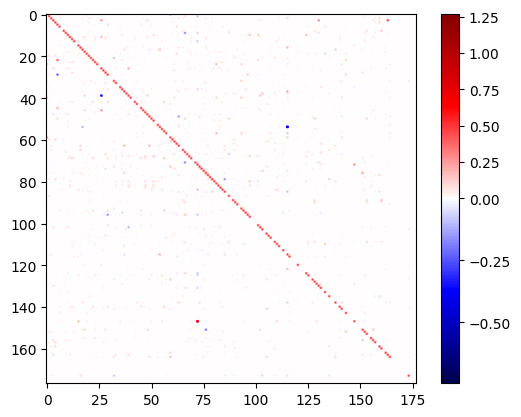

In [30]:
plt.imshow(M_norm, cmap='seismic', norm=TwoSlopeNorm(0))
plt.colorbar()

### Stationary distribution

In [43]:
evals, evecs = np.linalg.eig(M_norm.T)
evec1 = evecs[:,np.isclose(evals, 1, 1e-2)] # Increase the tolerance a little
evec1 = evec1[:,0]
stationary = evec1 / evec1.sum()
stationary = stationary.real

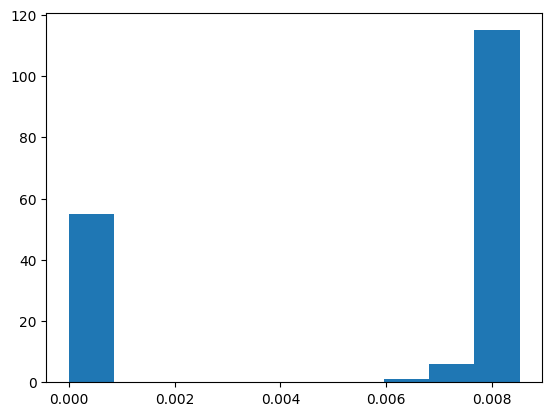

In [60]:
_ = plt.hist(stationary)

most of the players have a probability around to 0.08 % 

In [78]:
players_ranked[players_ranked.position == 'ata'][stationary > 0.008]

,rank,nickname,id,position,price,team
1,0.0,Vagner Love,38959,ata,5.10,ACG
7,1.0,Hulk,39148,ata,14.21,CAM
22,3.0,Alan Kardec,50347,ata,4.11,CAM
28,4.0,Léo Gamalho,53865,ata,4.11,VIT
33,5.0,Gilberto,61188,ata,5.22,JUV
...,...,...,...,...,...,...
622,157.0,Barreal,126471,ata,5.56,CRU
629,160.0,William Gomes,128668,ata,1.56,SAO
635,163.0,Luciano Giménez,129202,ata,1.99,CUI
637,164.0,Max,129766,ata,1.55,ACG


The best we dont know, but let take a look in the worst

In [89]:
players_ranked[players_ranked.position == 'ata'][(stationary > 0) * (stationary < 0.007)]

,rank,nickname,id,position,price,team
538,115.0,Flaco López,113103,ata,5.6,PAL


## Test sections

In [ ]:
from cartolafc import Api
import pandas as pd

In [ ]:
api = Api()

In [ ]:
api.partidas(0)

[{"data": {"year": 2024, "month": 5, "day": 11, "hour": 16, "minute": 0, "second": 0, "microsecond": 0, "tzinfo": null}, "local": "Maracan\u00e3", "clube_casa": {"id": 262, "nome": "Flamengo", "abreviacao": "FLA"}, "placar_casa": 2, "clube_visitante": {"id": 264, "nome": "Corinthians", "abreviacao": "COR"}, "placar_visitante": 0},
 {"data": {"year": 2024, "month": 5, "day": 11, "hour": 21, "minute": 0, "second": 0, "microsecond": 0, "tzinfo": null}, "local": "Arena MRV", "clube_casa": {"id": 282, "nome": "Atl\u00e9tico-MG", "abreviacao": "CAM"}, "placar_casa": null, "clube_visitante": {"id": 284, "nome": "Gr\u00eamio", "abreviacao": "GRE"}, "placar_visitante": null},
 {"data": {"year": 2024, "month": 5, "day": 12, "hour": 16, "minute": 0, "second": 0, "microsecond": 0, "tzinfo": null}, "local": "Arena Barueri", "clube_casa": {"id": 275, "nome": "Palmeiras", "abreviacao": "PAL"}, "placar_casa": 0, "clube_visitante": {"id": 293, "nome": "Athl\u00e9tico-PR", "abreviacao": "CAP"}, "placar_

In [ ]:
api.mercado()

{"rodada_atual": 6, "status": [2, "Mercado fechado"], "times_escalados": 2241893, "fechamento": {"year": 2024, "month": 5, "day": 11, "hour": 15, "minute": 59, "second": 0, "microsecond": 0, "tzinfo": null}}

In [ ]:
api = Api()
max_rounds = api.mercado().rodada_atual 

players_performance = pd.DataFrame()
for round in range(1, max_rounds):
    players_round = api.resultados_atletas(round)

In [ ]:
players_round = api.resultados_atletas(1)

In [ ]:
for player in players_round:
    player.i

AttributeError: 'int' object has no attribute 'i'

In [ ]:
for _, player in players_round.items():
    print(player.to_)

{"id": 100079, "apelido": "Zaracho", "pontos": 2.6, "scout": {"DS": 2, "FC": 2, "FF": 1}, "posicao": [4, "Meia", "mei"], "clube": {"id": 282, "nome": "Atl\u00e9tico-MG", "abreviacao": "CAM"}, "status": null, "is_capitao": null, "preco": null, "entrou_em_campo": true}
{"id": 100084, "apelido": "Igor Gomes", "pontos": 1.4, "scout": {"FC": 1, "FD": 1, "FS": 1}, "posicao": [4, "Meia", "mei"], "clube": {"id": 282, "nome": "Atl\u00e9tico-MG", "abreviacao": "CAM"}, "status": null, "is_capitao": null, "preco": null, "entrou_em_campo": true}
{"id": 100085, "apelido": "Pedro Augusto", "pontos": 5, "scout": {"A": 1}, "posicao": [4, "Meia", "mei"], "clube": {"id": 356, "nome": "Fortaleza", "abreviacao": "FOR"}, "status": null, "is_capitao": null, "preco": null, "entrou_em_campo": true}
{"id": 100652, "apelido": "Yuri Alberto", "pontos": 1.3, "scout": {"CA": 1, "DS": 1, "FC": 3, "FS": 4}, "posicao": [5, "Atacante", "ata"], "clube": {"id": 264, "nome": "Corinthians", "abreviacao": "COR"}, "status": 